# Imports

In [1]:
%matplotlib inline
import sys 
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import random
import pickle
from pathlib import Path
from itertools import product

modpath = "../scripts"
sys.path.append(os.path.abspath(modpath))

from misc import pickler, open_table
import plot_utils

/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
npg = plot_utils.npg_palette(); jco = plot_utils.jco_palette(); colors=plot_utils.matplotlib_init()
sns.set_style("whitegrid", {'axes.linewidth': 2, 'axes.edgecolor':'black'})

bbox=dict(boxstyle="round", fc="1",ec="0.8")

combined_td = pd.read_csv("../data/multi/combined_td.p1.csv", index_col=0) # Only post hoc fold change thresholds
combined_td2 = pd.read_csv("../data/multi/combined_td.p2.csv", index_col=0) # Formal fold change thresholds

combined_gsea_td = pd.read_csv(f"../data/multi/combined_gsea_td.csv", index_col=0)
dataorder = combined_td["Data"].drop_duplicates().values

datasetsfile = "../data/multi/datasets.txt"
with open(datasetsfile, "rb") as f:
    datasets = pickle.load(f)
    
DEAs = ["edgerlrt", "edger", "deseq2"]
outlier_methods = ["none","jk","pcah"]
all_N = [3,4,5,6,7,8,9,10,12,15]

# pretty names
prdea = {"edgerlrt":"edgeR LRT","edger":"edgeR QLF","deseq2":"DESeq2 Wald"}
prout = {"none":"None","jk":"Jackknife","pcah":"rPCA"}

sites = {"thyroid": "THCA",
         "lung": "LUAD",
         "kidney": "KIRC",
         "colorectal": "COAD",
         "breast": "BRCA",
         "liver": "LIHC",
         "prostate": "PRAD"}

if "KIRC_syn_hom" in datasets:
    del datasets["KIRC_syn_hom"]
    
ix = combined_td[combined_td["DEA"]=="DESeq2"].index
combined_td.loc[ix,"DEA"] = "DESeq2 Wald"
ix = combined_td2[combined_td2["DEA"]=="DESeq2"].index
combined_td2.loc[ix,"DEA"] = "DESeq2 Wald"

## Calculate expected metrics under the null model

In [3]:
from urn import random_jacc_rep,random_metrics

mean_genes = np.mean([datasets[d]["genes"] for d in datasets])

for i, c in enumerate([combined_td, combined_td2]):
    c["rnd_rep"] = random_jacc_rep(c["median_deg"]/mean_genes)
    
for dea in ["edger","edgerlrt","deseq2"]:
    deg_truth_lfc0 = np.mean([datasets[d]["truth_stats"][0][0.05][0][dea] for d in datasets])
    deg_truth_lfc0_post1 = np.mean([datasets[d]["truth_stats"][0][0.05][1][dea] for d in datasets])
    deg_truth_lfc1 = np.mean([datasets[d]["truth_stats"][1][0.05][1][dea] for d in datasets])
    
    for i, c in enumerate([combined_td, combined_td2]):
        deg_truth = deg_truth_lfc0 if i == 0 else deg_truth_lfc1
        cc = c[c["DEA"]==prdea[dea]]
        a=cc["median_deg"].apply(lambda x: random_metrics(x, mean_genes, deg_truth, w=1))
        ix = a.index
        c.loc[ix, "rnd_mcc"] = [aa[0][0] if isinstance(aa[0], np.ndarray) else np.nan for aa in a]
        c.loc[ix, "rnd_prec"] = [aa[1][0] if isinstance(aa[0], np.ndarray) else np.nan for aa in a]
        c.loc[ix, "rnd_rec"] = [aa[2][0] if isinstance(aa[0], np.ndarray) else np.nan for aa in a]
        
        # post hoc FC threshold
        if i == 0:
            cc = cc[cc["logFC"] == 1]
            deg_truth = deg_truth_lfc0_post1
            a=cc["median_deg"].apply(lambda x: random_metrics(x, mean_genes, deg_truth, w=1))
            ix = a.index
            c.loc[ix, "rnd_mcc"] = [aa[0][0] if isinstance(aa[0], np.ndarray) else np.nan for aa in a]
            c.loc[ix, "rnd_prec"] = [aa[1][0] if isinstance(aa[0], np.ndarray) else np.nan for aa in a]
            c.loc[ix, "rnd_rec"] = [aa[2][0] if isinstance(aa[0], np.ndarray) else np.nan for aa in a]

In [4]:
# combine results from post hoc and formal thresholds into one dataframe

a = combined_td2.copy()
a["logFC"] = "test"
combined_td3 = pd.concat([combined_td,a])
combined_td3 = combined_td3.reset_index(drop=True)
combined_td3.to_csv(f"../data/multi/combined_td_post_and_test.csv")

gsea_truth = open_table(f"../data/multi/gsea_truth_df.csv")

# Figure 1

- #DEGS vs N
- Replicability vs N

../figures/R_vs_N_None.pdf


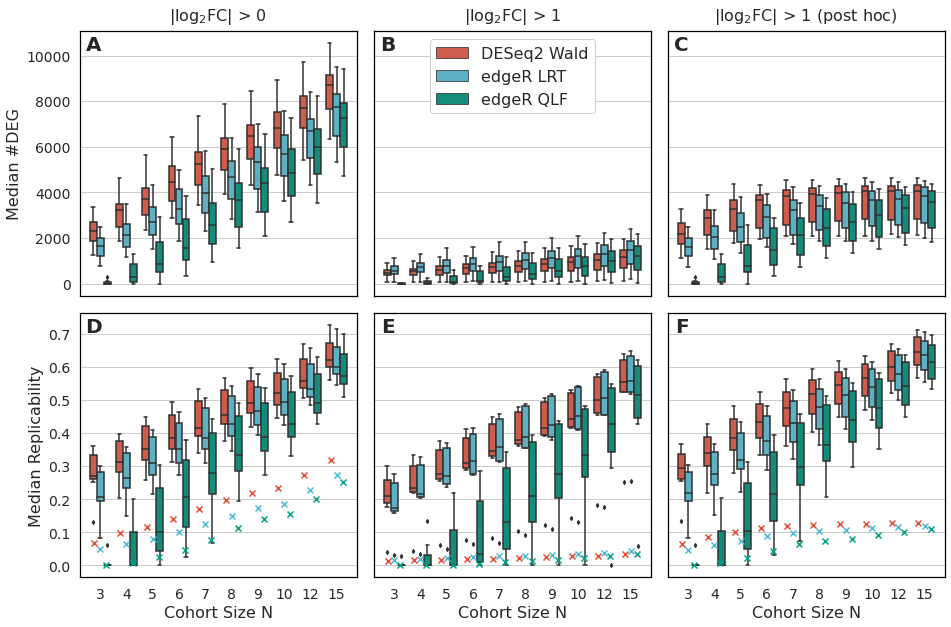

In [59]:
from urn import random_jacc_rep

fig, ax = plt.subplots(2,3,figsize=(13.5,9), sharex=True, sharey="row")
ax = ax.flatten()

outlier_method = "None"
FDR = 0.05
fs = 3 # fliersize

logFC = 0
comb_e = combined_td[(combined_td["Out"] == outlier_method) & (combined_td["logFC"] == logFC) & (combined_td["FDR"] == FDR)]
comb_e = comb_e.sort_values(by="DEA")
sns.boxplot(data=comb_e,x="N",y="median_rep",hue="DEA",ax=ax[3], palette=np.array(npg)[[0,1,2]], fliersize=fs)
sns.boxplot(data=comb_e,x="N",y="median_deg",hue="DEA",ax=ax[0], palette=np.array(npg)[[0,1,2]], fliersize=fs)

# TREAT
logFC = 1
comb_e = combined_td2[(combined_td2["Out"] == outlier_method) & (combined_td2["logFC"] == logFC) & (combined_td2["FDR"] == FDR)]
comb_e = comb_e.sort_values(by="DEA")
sns.boxplot(data=comb_e,x="N",y="median_rep",hue="DEA",ax=ax[4], palette=np.array(npg)[[0,1,2]], fliersize=fs)
sns.boxplot(data=comb_e,x="N",y="median_deg",hue="DEA",ax=ax[1], palette=np.array(npg)[[0,1,2]], fliersize=fs)

# POST HOC FC THRESHOLD
comb_e = combined_td[(combined_td["Out"] == outlier_method) & (combined_td["logFC"] == logFC) & (combined_td["FDR"] == FDR)]
comb_e = comb_e.sort_values(by="DEA")
sns.boxplot(data=comb_e,x="N",y="median_rep",hue="DEA",ax=ax[5], palette=np.array(npg)[[0,1,2]], fliersize=fs)
sns.boxplot(data=comb_e,x="N",y="median_deg",hue="DEA",ax=ax[2], palette=np.array(npg)[[0,1,2]], fliersize=fs)

for i, a in enumerate(ax) :
    a.legend([],[], frameon=False)
    a.set(xlabel=None, ylabel=None)
    a.annotate(chr(ord('A')+i), xy=(0.05, 0.95), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)
    
ax[0].set_ylabel("Median #DEG")
ax[3].set_ylabel("Median Replicability")
for a in ax[3:]: a.set_xlabel("Cohort Size N")

ax[0].set_title(r"|log$_2$FC| > 0", fontsize=16, pad=11)
ax[1].set_title(r"|log$_2$FC| > 1", fontsize=16, pad=11)
ax[2].set_title(r"|log$_2$FC| > 1 (post hoc)", fontsize=16, pad=11)

handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles, labels, loc='upper center',framealpha=1)

# plot expected rep from random genes
N = np.mean([datasets[s]["genes"] for s in datasets])
combined_td["rnd_rep"] = random_jacc_rep(combined_td["median_deg"]/N)
combined_td2["rnd_rep"] = random_jacc_rep(combined_td2["median_deg"]/N)


for logFC in [0,1,"post"]:
    a = ax[3] if logFC == 0 else ax[4]
    if logFC == "post":
        logFC = 1
        a = ax[5]
        
    c = combined_td2 if a == ax[4] else combined_td
    comb_e = c[(c["Out"] == outlier_method) & (c["logFC"] == logFC) & (c["FDR"] == FDR)]
    for k, N in enumerate(set(combined_td["N"])):
        for dea in set(combined_td["DEA"]):
            comb_ee = comb_e[(comb_e["N"]==N)&(comb_e["DEA"]==dea)]
            rnd_rep = comb_ee["rnd_rep"].median()
            if dea == "edgeR QLF": x, col = k+0.23, npg[2]
            elif dea == "DESeq2 Wald": x, col = k-0.23, npg[0]
            else: x, col = k, npg[1]
            a.scatter(x,rnd_rep,marker="x",color=col,zorder=99)
            
figpath = f"../figures/fig1_R_vs_N_{outlier_method}.pdf"
fig.tight_layout()
fig.savefig(figpath)
print(figpath)

# Figure 2

- Precision vs N
- Precision vs FDR

In [60]:
FDRs = [1e-4,0.001,0.01,0.05,0.1,0.2,0.5]
cancers = [d for d in datasets]
cohorts = 100
lfcs = [0,1,"post"]
overwrite = False

def make_prec_df():
    vals = ["Precision","#DEGs","Precision_Mean","#DEGs_Mean"]
    iterables = [cancers,all_N,["none"],DEAs,FDRs,[0,1,"post"],vals]
    multi_cols = pd.MultiIndex.from_product(iterables, names=["Data", "N", "Out", "DEA", "FDR", "logFC","Val"])
    prec_df = pd.DataFrame(columns=multi_cols)

    all_fdr_dict = {fdr:{lfc: {"truth":None,"precs":[],"n_degs":[]} for lfc in lfcs} for fdr in FDRs}

    for site in sites:

        data = sites[site]
        for lfc in lfcs:
            param_set = "p2" if lfc == 1 else "p1"
            lfc_suffix = 0 if lfc == "post" else lfc
            for dea in DEAs:
                f = f"../data/{site}/{data}/{data}.{dea}.lfc{lfc_suffix}"
                truth_tool = open_table(f)
                

                for fdr in FDRs:
                    precs,n_degs = [],[]
                    truth_tool_fdr = truth_tool[truth_tool["FDR"]<fdr]
                    if lfc == "post":
                        truth_tool_fdr = truth_tool_fdr[truth_tool_fdr["logFC"].abs()>1]
                    all_fdr_dict[fdr][lfc]["truth"] = truth_tool_fdr


                for out in ["none"]:# outlier_methods:
                    print(site,dea,out,lfc)

                    for i,N in enumerate(all_N):


                        for fdr in FDRs:
                            all_fdr_dict[fdr][lfc]["precs"], all_fdr_dict[fdr][lfc]["n_degs"] = [], []

                        for cohort in range(1,cohorts+1):
                            cf = f"../data/{site}/{data}/{data}_N{N}/{data}_N{N}_{cohort:04}/tab.{out}.{dea}.{param_set}"
                            ct = open_table(cf)

                            for fdr in FDRs:
                                degs = ct[ct["FDR"]<fdr]
                                truth_tool_fdr = all_fdr_dict[fdr][lfc]["truth"]
                                if lfc == "post":
                                    degs = degs[degs["logFC"].abs()>1]
                                TP_tool = degs.index.intersection(truth_tool_fdr.index)
                                prec_tool = len(TP_tool)/len(degs) if len(degs) > 0 else np.nan
                                all_fdr_dict[fdr][lfc]["precs"].append(prec_tool)
                                all_fdr_dict[fdr][lfc]["n_degs"].append(len(degs))

                        for fdr in FDRs:
                            prec_df.loc[0,(data,N,out,dea,fdr,lfc,"Precision")] = np.nanmedian(all_fdr_dict[fdr][lfc]["precs"])
                            prec_df.loc[0,(data,N,out,dea,fdr,lfc,"#DEGs")] = np.nanmedian(all_fdr_dict[fdr][lfc]["n_degs"])
                            prec_df.loc[0,(data,N,out,dea,fdr,lfc,"Precision_Mean")] = np.nanmean(all_fdr_dict[fdr][lfc]["precs"])
                            prec_df.loc[0,(data,N,out,dea,fdr,lfc,"#DEGs_Mean")] = np.nanmean(all_fdr_dict[fdr][lfc]["n_degs"])
    return prec_df

if overwrite:
    prec_df = make_prec_df()
    prec_df = prec_df.unstack().unstack(level="Val").reset_index(level=["Data", "N", "Out", "DEA", "FDR", "logFC"], drop=False)
    prec_df.reset_index(drop=True, inplace=True)

    for clean in prout:
        prec_df.loc[(prec_df[prec_df["Out"] == clean]).index, "Out"] = prout[clean]
    for clean in prdea:
        prec_df.loc[(prec_df[prec_df["DEA"] == clean]).index, "DEA"] = prdea[clean]
    prec_df.to_csv(f"../data/multi/prec_df_nan.csv")
    
else:
    prec_df = pd.read_csv(f"../data/multi/prec_df_nan.csv", index_col=0)

ix = prec_df[prec_df["DEA"]=="DESeq2"].index
prec_df.loc[ix,"DEA"] = "DESeq2 Wald"
prec_df.head()

,Data,N,Out,DEA,FDR,logFC,#DEGs,#DEGs_Mean,Precision,Precision_Mean
0,BRCA,3,None,DESeq2 Wald,0.0001,0,420.5,546.78,0.975146,0.966127
1,BRCA,3,None,DESeq2 Wald,0.0001,1,95.0,159.08,0.922355,0.919643
2,BRCA,3,None,DESeq2 Wald,0.0001,post,420.5,546.78,0.949559,0.937423
3,BRCA,3,None,DESeq2 Wald,0.0010,0,694.5,829.40,0.970965,0.963440
4,BRCA,3,None,DESeq2 Wald,0.0010,1,159.5,233.66,0.921311,0.912888


0.6970068889064851
0.11212289175706713
0.1895478660226463
../figures/precision_vs_n_fdr.pdf


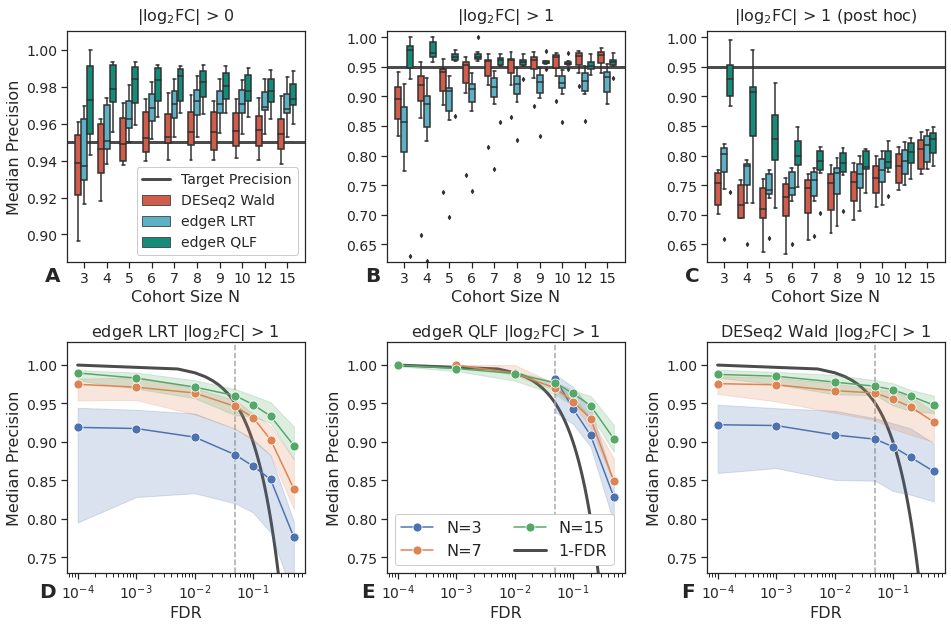

In [61]:
sns.set_style("ticks")
fig, ax = plt.subplots(2,3,figsize=(13.5,9), sharex=False, sharey=False)
ax = ax.flatten()

outlier_method = "None"
FDR = 0.05
palette = np.array(npg)[[0,1,2]]
z = 2
fs = 3

#### PRECISION VS. N ####

# No fold change threshold
logFC = 0
comb_e = combined_td3[(combined_td3["Out"] == outlier_method) & (combined_td3["logFC"] == logFC) & (combined_td3["FDR"] == FDR)]
comb_e = comb_e.sort_values(by="DEA")
sns.boxplot(data=comb_e,x="N",y="median_prec",hue="DEA",ax=ax[0], palette=palette, zorder=z, whiskerprops={"zorder":z}, boxprops={"zorder":z},  fliersize=fs)

# TREAT
logFC = "test"
comb_e = combined_td3[(combined_td3["Out"] == outlier_method) & (combined_td3["logFC"] == logFC) & (combined_td3["FDR"] == FDR)]
comb_e = comb_e.sort_values(by="DEA")
sns.boxplot(data=comb_e,x="N",y="median_prec",hue="DEA",ax=ax[1], palette=palette, zorder=z, whiskerprops={"zorder":z}, boxprops={"zorder":z},  fliersize=fs)
#prad = comb_e[comb_e["Data"]=="PRAD"]
#display(prad.sort_values(by="median_prec").head()[comb_e.columns[:-5]])

# POST HOC FC THRESHOLD
logFC = 1
comb_e = combined_td3[(combined_td3["Out"] == outlier_method) & (combined_td3["logFC"] == logFC) & (combined_td3["FDR"] == FDR)]
comb_e = comb_e.sort_values(by="DEA")
sns.boxplot(data=comb_e,x="N",y="median_prec",hue="DEA",ax=ax[2], palette=palette, zorder=z, whiskerprops={"zorder":z}, boxprops={"zorder":z},  fliersize=fs)

# plot expected metrics from random genes

for i, logFC in enumerate([0,"test",1]):

    met = "rnd_prec"
    comb_e = combined_td3[(combined_td3["Out"] == outlier_method) & (combined_td3["logFC"] == logFC) & (combined_td3["FDR"] == FDR)]
    
    a = ax[i]
    null_precision = comb_e[met].median()
    print(null_precision)
    a.scatter(0,null_precision,color="black", alpha=0.8, zorder=0,marker="x") #label=f"Null Precision: {null_precision:.2f}"
    
    for k, N in enumerate(set(combined_td["N"])):
        for dea in set(combined_td["DEA"]):
            comb_ee = comb_e[(comb_e["N"]==N)&(comb_e["DEA"]==dea)]
            rnd = comb_ee[met].median()
            if dea == "edgeR QLF": x, c = k+0.23, npg[2]
            elif dea == "DESeq2": x, c = k-0.23, npg[0]
            else: x, c = k, npg[1]
            a.scatter(x,rnd,marker="x",color=c,zorder=99)
            
ax[0].set_title(r"|log$_2$FC| > 0", fontsize=16, pad=11)
ax[1].set_title(r"|log$_2$FC| > 1", fontsize=16, pad=11)
ax[2].set_title(r"|log$_2$FC| > 1 (post hoc)", fontsize=16, pad=11)
            
for i, a in enumerate(ax[:3]):
    a.legend([],[], frameon=False)
    a.set(xlabel="Cohort Size N", ylabel=None)
    a.axhline(0.95, ls="-",color="black", alpha=0.7,label="Target Precision",lw=3, zorder=1)
    a.annotate(chr(ord('A')+i), xy=(-0.06, -0.06), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)

ax[0].set_ylabel("Median Precision")

ax[0].set_ylim(0.885,1.01)
ax[1].set_ylim(0.62,1.01)
ax[2].set_ylim(0.62,1.01)

for a in ax[:1]:
    handles, labels = a.get_legend_handles_labels()
    #handles, labels = [handles[0],handles[-1]], [labels[0],labels[-1]]
    loc = "lower right" if a != ax[2] else "upper right"
    a.legend(handles, labels, loc=loc, framealpha=1, fontsize=14)
    
    
#### PRECISION VS. FDR ####
lfc = "1"
FDRs = [1e-4,0.001,0.01,0.05,0.1,0.2,0.5]
cancers = [d for d in datasets if "syn" not in d]

def rm_nan_prec(prec_df):
    """Remove FDRs where precision could not be determined"""
    c=prec_df.groupby("FDR")
    for cc in c:
        if cc[1]["Precision"].isna().sum() > 0:
            prec_df = prec_df[prec_df["FDR"]!=cc[0]]
    return prec_df

for i,dea in enumerate(prdea):
    i+=3
    dea = prdea[dea]
    
    a = prec_df[(prec_df["DEA"]==dea)&(prec_df["N"]==3)&(prec_df["logFC"]==lfc)]
    c=a.groupby("FDR")
    for cc in c:
        if cc[1]["Precision"].isna().sum() > 0:
            a = a[a["FDR"]!=cc[0]]
            
    if (len(a)>0): sns.lineplot(data=a,x="FDR",y="Precision",ax=ax[i], color=sns.color_palette()[0], marker="o",ms=9,label="N=3",estimator=np.median)
    else: sns.lineplot(x=[-1],y=[-1],ax=ax[i], color=sns.color_palette()[0], marker="o",ms=9,label="N=3",estimator=np.median) # dummy for legend
    
    a = prec_df[(prec_df["DEA"]==dea)&(prec_df["N"]==7)&(prec_df["logFC"]==lfc)]
    c=a.groupby("FDR")
    for cc in c:
        if cc[1]["Precision"].isna().sum() > 0:
            a = a[a["FDR"]!=cc[0]]
            
    if (len(a)>0): sns.lineplot(data=a,x="FDR",y="Precision",ax=ax[i], color=sns.color_palette()[1], marker="o",ms=9,label="N=7",estimator=np.median)
    else: sns.lineplot(x=[-1],y=[-1],ax=ax[i], color=sns.color_palette()[1], marker="o",ms=9,label="N=7",estimator=np.median) # dummy for legend
    
    a = prec_df[(prec_df["DEA"]==dea)&(prec_df["N"]==15)&(prec_df["logFC"]==lfc)]
    a = rm_nan_prec(a)
            
    if (len(a)>0): sns.lineplot(data=a,x="FDR",y="Precision",ax=ax[i], color=sns.color_palette()[2], marker="o",ms=9,label="N=15",estimator=np.median)
    else: sns.lineplot(x=[-1],y=[-1],ax=ax[i], color=sns.color_palette()[2], marker="o",ms=9,label="N=15",estimator=np.median) # dummy for legend
    
    ax[i].set(xscale="log",ylabel="Median Precision",ylim=(0.73,1.03))
    x = np.linspace(min(FDRs),max(FDRs),100)
    ax[i].plot(x,1-x,color="black",lw=3, alpha=0.7,label="1-FDR",zorder=0)
    
    if i == 4: ax[i].legend(framealpha=1,ncol=2)
    else: ax[i].legend([],[], frameon=False)
    ax[i].set_title(rf"{dea} |log$_2$FC| > 1", fontsize=16)
    
    ax[i].axvline(0.05,ls="--",c="darkgrey",zorder=0)
    
for i, aa in enumerate(ax[3:]) :
    aa.annotate(chr(ord('A')+i+3), xy=(-0.08, -0.08), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)

figpath = f"../figures/fig2_precision_vs_n_fdr.pdf"
fig.tight_layout()
fig.savefig(figpath)
print(figpath)

# Figure 3

- MCC vs N
- Recall vs N

../figures/mcc_recall_vs_N_None.pdf


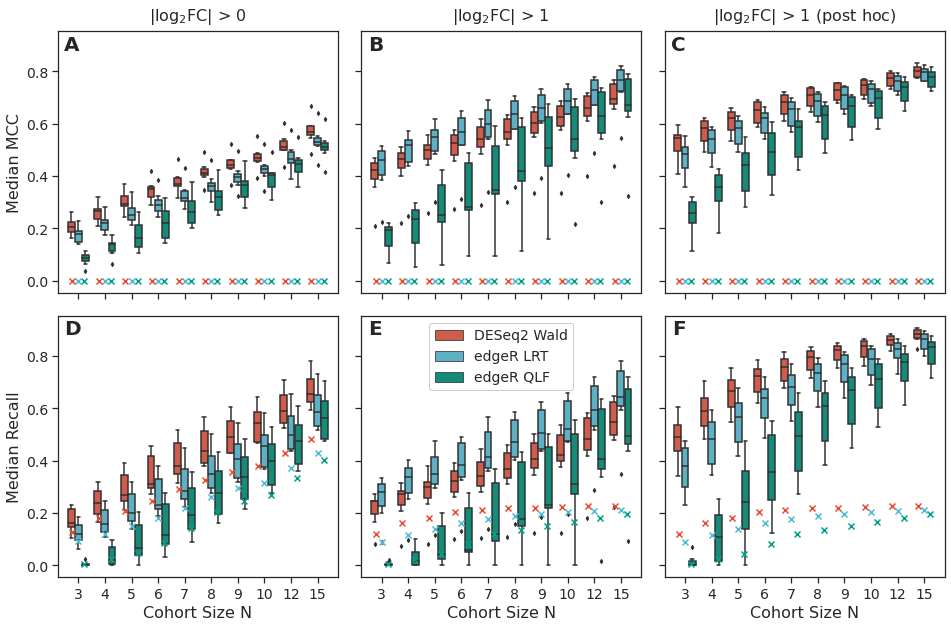

In [63]:
fig, ax = plt.subplots(2,3,figsize=(13.5,9), sharex=True, sharey=True)
ax = ax.flatten()

outlier_method = "None"
FDR = 0.05
palette = np.array(npg)[[0,1,2]]
z = 2
fs = 3

logFC = 0
comb_e = combined_td[(combined_td["Out"] == outlier_method) & (combined_td["logFC"] == logFC) & (combined_td["FDR"] == FDR)]
comb_e = comb_e.sort_values(by="DEA")
sns.boxplot(data=comb_e,x="N",y="median_mcc",hue="DEA",ax=ax[0], palette=palette, zorder=z, whiskerprops={"zorder":z}, boxprops={"zorder":z},  fliersize=fs)
sns.boxplot(data=comb_e,x="N",y="median_rec",hue="DEA",ax=ax[3], palette=palette, zorder=z, whiskerprops={"zorder":z}, boxprops={"zorder":z},  fliersize=fs)

# TREAT
logFC = 1
comb_e = combined_td2[(combined_td2["Out"] == outlier_method) & (combined_td2["logFC"] == logFC) & (combined_td2["FDR"] == FDR)]
comb_e = comb_e.sort_values(by="DEA")

sns.boxplot(data=comb_e,x="N",y="median_mcc",hue="DEA",ax=ax[1], palette=palette, zorder=z, whiskerprops={"zorder":z}, boxprops={"zorder":z},  fliersize=fs)
sns.boxplot(data=comb_e,x="N",y="median_rec",hue="DEA",ax=ax[4], palette=palette, zorder=z, whiskerprops={"zorder":z}, boxprops={"zorder":z},  fliersize=fs)

# POST HOC FC THRESHOLD
comb_e = combined_td[(combined_td["Out"] == outlier_method) & (combined_td["logFC"] == logFC) & (combined_td["FDR"] == FDR)]
comb_e = comb_e.sort_values(by="DEA")
sns.boxplot(data=comb_e,x="N",y="median_mcc",hue="DEA",ax=ax[2], palette=palette, zorder=z, whiskerprops={"zorder":z}, boxprops={"zorder":z},  fliersize=fs)
sns.boxplot(data=comb_e,x="N",y="median_rec",hue="DEA",ax=ax[5], palette=palette, zorder=z, whiskerprops={"zorder":z}, boxprops={"zorder":z},  fliersize=fs)

# # plot expected metrics from random genes

for i, logFC in enumerate([0,1,"post"]):
    for j, met in enumerate(["rnd_mcc","rnd_rec"]):
        
        if logFC == "post":
            logFC =1
            a = ax[2] if j == 0 else ax[5]
        else:
            a = ax[i] if j == 0 else ax[i+3]

        c = combined_td3
        comb_e = c[(c["Out"] == outlier_method) & (c["logFC"] == logFC) & (c["FDR"] == FDR)]

        for k, N in enumerate(set(combined_td3["N"])):
            for dea in set(combined_td3["DEA"]):
                comb_ee = comb_e[(comb_e["N"]==N)&(comb_e["DEA"]==dea)]
                rnd = comb_ee[met].median()
                if dea == "edgeR QLF": x, c = k+0.23, npg[2]
                elif dea == "DESeq2 Wald": x, c = k-0.23, npg[0]
                else: x, c = k, npg[1]
                a.scatter(x,rnd,marker="x",color=c,zorder=99)
            
for i, a in enumerate(ax):
    a.legend([],[], frameon=False)
    a.set(xlabel="Cohort Size N" if i > 2 else "", ylabel=None)
    a.annotate(chr(ord('A')+i), xy=(0.05, 0.95), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)

handles, labels = ax[4].get_legend_handles_labels()
ax[4].legend(handles, labels, loc='upper center',framealpha=1, fontsize=14)
    
ax[0].set_title(r"|log$_2$FC| > 0", fontsize=16, pad=11)
ax[1].set_title(r"|log$_2$FC| > 1", fontsize=16, pad=11)
ax[2].set_title(r"|log$_2$FC| > 1 (post hoc)", fontsize=16, pad=11)

for a in ax[7:]: a.set(xlabel="Cohort Size (N)")
ax[3].set_ylabel("Median Recall")
ax[0].set_ylabel("Median MCC")

figpath = f"../figures/fig3_mcc_recall_vs_N_{outlier_method}.pdf"
fig.tight_layout()
fig.savefig(figpath)
print(figpath)

# Figures 4, S5-S8

Enrichment metrics vs N

- Replicability (figure 4)
- MCC (supplementary figure 5)
- Precision (supplementary figure 6)
- Recall (supplementary figure 7)
- \#Terms (supplementary figure 8)

In [6]:
combined_gsea_td = pd.read_csv(f"../data/multi/combined_gsea_td.csv", index_col=0)
combined_gsea_td["DEA_Enrichment"] = combined_gsea_td["DEA"] + "_" + combined_gsea_td["Enrichment"]

for d in datasets:
    for out in ["None"]:
        for dea in DEAs:
            dea = prdea[dea]
            dea = "DESeq2" if dea.endswith("Wald") else dea
            for enrichment in set(gsea_truth["Enrichment"]):
                for lib in set(gsea_truth["Library"]):
                    for fdr in [0.05]:
                        g=gsea_truth[(gsea_truth["Data"]==d)&(gsea_truth["Out"]==out)&(gsea_truth["DEA"]==dea)&(gsea_truth["Enrichment"]==enrichment)&(gsea_truth["Library"]==lib)]
                        c=combined_gsea_td[(combined_gsea_td["Data"]==d)&(combined_gsea_td["Out"]==out)&(combined_gsea_td["DEA"]==dea)&(combined_gsea_td["Enrichment"]==enrichment)&(combined_gsea_td["Library"]==lib)].index
                        try:
                            combined_gsea_td.loc[c,"truth"] = g["truth"].values[0]
                            combined_gsea_td.loc[c,"truth_common"] = g["truth_common"].values[0]
                        except IndexError:

                            combined_gsea_td.loc[c,"truth"] = np.nan
                            combined_gsea_td.loc[c,"truth_common"] = np.nan

In [7]:
comb = combined_gsea_td.dropna()

GSEA = ["edgeR QLF_gseapy_s2n", "edgeR QLF_gseapy"]
ORA = [a for a in list(comb["DEA_Enrichment"].value_counts().index) if "gsea" not in a]

comb = comb[comb["DEA_Enrichment"].isin(GSEA+ORA)]

comb["DEA_Enrichment"] = comb["DEA"] + " " + comb["Enrichment"] 

comb["DEA_Enrichment"] = comb["DEA_Enrichment"].str.replace("clusterORA_lfc", "ORA")
comb["DEA_Enrichment"] = comb["DEA_Enrichment"].str.replace("clusterORA", "ORA")
comb["DEA_Enrichment"] = comb["DEA_Enrichment"].str.replace(".fdr0.05.post_lfc0.lfc0", " |logFC| > 0")
comb["DEA_Enrichment"] = comb["DEA_Enrichment"].str.replace(".fdr0.05.post_lfc1.lfc0", " |logFC| > 1 (post hoc)")
comb["DEA_Enrichment"] = comb["DEA_Enrichment"].str.replace(".fdr0.05.post_lfc1.lfc1", " |logFC| > 1")

comb["DEA_Enrichment"] = comb["DEA_Enrichment"].str.replace("DESeq2 gseapy", "GSEA")
comb["DEA_Enrichment"] = comb["DEA_Enrichment"].str.replace("edgeR LRT gseapy", "GSEA")
comb["DEA_Enrichment"] = comb["DEA_Enrichment"].str.replace("edgeR QLF gseapy", "GSEA")

comb["DEA_Enrichment"] = comb["DEA_Enrichment"].str.replace("GSEA", "logFC Ranking")
comb["DEA_Enrichment"] = comb["DEA_Enrichment"].str.replace("logFC Ranking_s2n", "|S2N| Ranking")

comb.sort_values(by="DEA",inplace=True) # for correct order in plot
comb_gsea = comb

l = list(comb_gsea.columns)
l.remove("DEA_Enrichment")
comb_gsea = comb_gsea[["DEA_Enrichment"]+l]

/scratch/local/64349568/ipykernel_24302/2746066233.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  comb["DEA_Enrichment"] = comb["DEA_Enrichment"].str.replace(".fdr0.05.post_lfc0.lfc0", " |logFC| > 0")
/scratch/local/64349568/ipykernel_24302/2746066233.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  comb["DEA_Enrichment"] = comb["DEA_Enrichment"].str.replace(".fdr0.05.post_lfc1.lfc0", " |logFC| > 1 (post hoc)")
/scratch/local/64349568/ipykernel_24302/2746066233.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  comb["DEA_Enrichment"] = comb["DEA_Enrichment"].str.replace(".fdr0.05.post_lfc1.lfc1", " |logFC| > 1")


In [ ]:
from urn import random_jacc_rep,random_metrics

with open("../data/multi/common_gobp.txt", "rb") as f:
    common_gobp = pickle.load(f)
with open("../data/multi/common_kegg.txt", "rb") as f:
    common_kegg = pickle.load(f)
        
go_terms, kegg_terms = len(common_gobp), len(common_kegg)
go_ix = comb_gsea[comb_gsea["Library"]=="GO_Biological_Process_2021"].index
kegg_ix = comb_gsea[comb_gsea["Library"]=="KEGG_2021_Human"].index

comb_gsea.loc[go_ix,"rnd_rep_common"] = random_jacc_rep(comb_gsea.loc[go_ix,"median_terms_common"]/go_terms)
comb_gsea.loc[kegg_ix, "rnd_rep_common"] = random_jacc_rep(comb_gsea.loc[kegg_ix,"median_terms_common"]/kegg_terms)


for row in comb_gsea.loc[go_ix].index:
    met = random_metrics(comb_gsea.loc[row,"median_terms_common"], go_terms, comb_gsea.loc[row,"truth_common"], w=1)
    comb_gsea.loc[row,"rnd_mcc_common"],comb_gsea.loc[row,"rnd_prec_common"],comb_gsea.loc[row,"rnd_rec_common"] = met[0], met[1], met[2]

for row in comb_gsea.loc[kegg_ix].index:
    met = random_metrics(comb_gsea.loc[row,"median_terms_common"], kegg_terms, comb_gsea.loc[row,"truth_common"], w=1)
    comb_gsea.loc[row,"rnd_mcc_common"],comb_gsea.loc[row,"rnd_prec_common"],comb_gsea.loc[row,"rnd_rec_common"] = met[0], met[1], met[2]

../figures/sfig5_enrichment_mcc_vs_N_None.pdf


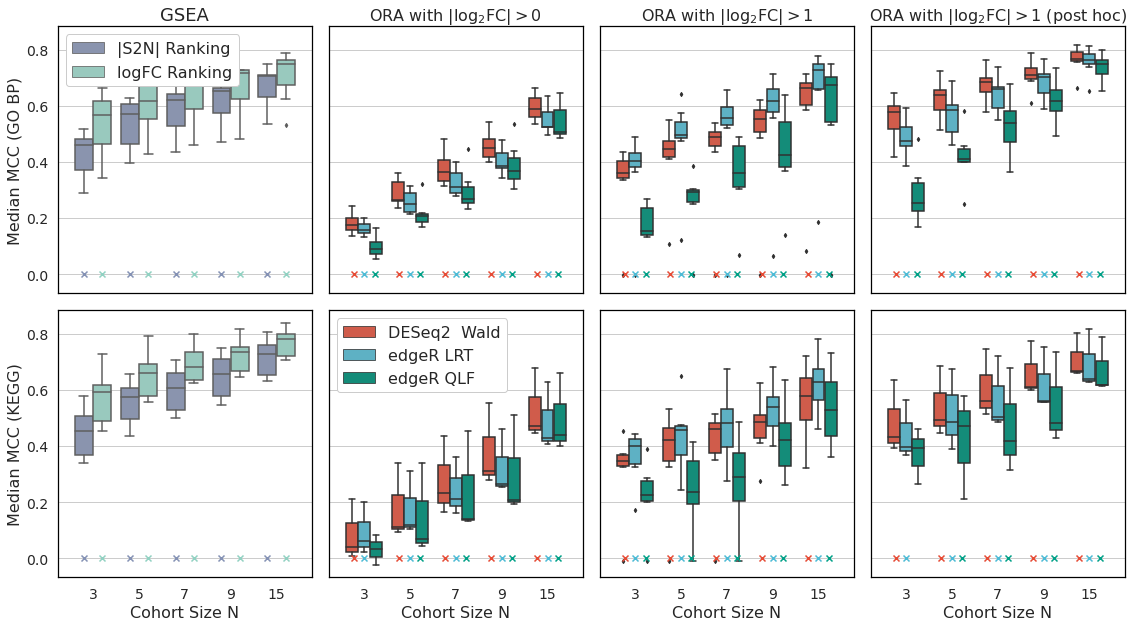

In [12]:
met = "rep_common"
#met = "mcc_common"
#met = "prec_common"
#met = "rec_common"
#met = "terms_common"

fig, ax = plt.subplots(2,4,figsize=(16,9), sharex=True, sharey = "row" if met.startswith("terms") else True)
ax = ax.flatten()
fs = 3
comb = comb_gsea
outlier_method = "None"
libraries = ["GO_Biological_Process_2021","KEGG_2021_Human"]
FDR = 0.05
palette = npg
palette2 = np.array(npg)[[5,6]]
GSEA = ["logFC Ranking", "|S2N| Ranking"]
ORA = [a for a in list(comb["DEA_Enrichment"].value_counts().index) if "Ranking" not in a]
# ORA_LFC0 = [a for a in ORA if "|logFC| > 1" not in a]
# ORA_LFC1 = [a for a in ORA if "|logFC| > 1" in a and "post hoc" not in a]
# ORA_LFC_POST = [a for a in ORA if "post hoc" in a]
ORA_LFC_POST = ['DESeq2 ORA |logFC| > 1 (post hoc)','edgeR LRT ORA |logFC| > 1 (post hoc)','edgeR QLF ORA |logFC| > 1 (post hoc)']
ORA_LFC1 = ['DESeq2 ORA |logFC| > 1','edgeR LRT ORA |logFC| > 1','edgeR QLF ORA |logFC| > 1']
ORA_LFC0 = ['DESeq2 ORA |logFC| > 0','edgeR LRT ORA |logFC| > 0','edgeR QLF ORA |logFC| > 0']

lib = "GO_Biological_Process_2021"
comb_ee = comb[(comb["Out"] == outlier_method) & (comb["Library"] == lib) & (comb["FDR"] == FDR)]
comb_eee=comb_ee[comb_ee["DEA_Enrichment"].isin(GSEA)]
sns.boxplot(data=comb_eee,x="N",y=f"median_{met}",hue="DEA_Enrichment",ax=ax[0], palette=palette2, fliersize=fs)
comb_eee=comb_ee[comb_ee["DEA_Enrichment"].isin(ORA_LFC0)]
sns.boxplot(data=comb_eee,x="N",y=f"median_{met}",hue="DEA_Enrichment",ax=ax[1], palette=palette, fliersize=fs)
comb_eee=comb_ee[comb_ee["DEA_Enrichment"].isin(ORA_LFC1)]
sns.boxplot(data=comb_eee,x="N",y=f"median_{met}",hue="DEA_Enrichment",ax=ax[2], palette=palette, fliersize=fs)
comb_eee=comb_ee[comb_ee["DEA_Enrichment"].isin(ORA_LFC_POST)]
sns.boxplot(data=comb_eee,x="N",y=f"median_{met}",hue="DEA_Enrichment",ax=ax[3], palette=palette, fliersize=fs)

lib = "KEGG_2021_Human"
comb_ee = comb[(comb["Out"] == outlier_method) & (comb["Library"] == lib) & (comb["FDR"] == FDR)]
comb_eee=comb_ee[comb_ee["DEA_Enrichment"].isin(GSEA)]
sns.boxplot(data=comb_eee,x="N",y=f"median_{met}",hue="DEA_Enrichment",ax=ax[4], palette=palette2, fliersize=fs)
comb_eee=comb_ee[comb_ee["DEA_Enrichment"].isin(ORA_LFC0)]
sns.boxplot(data=comb_eee,x="N",y=f"median_{met}",hue="DEA_Enrichment",ax=ax[5], palette=palette, fliersize=fs)
comb_eee=comb_ee[comb_ee["DEA_Enrichment"].isin(ORA_LFC1)]
sns.boxplot(data=comb_eee,x="N",y=f"median_{met}",hue="DEA_Enrichment",ax=ax[6], palette=palette, fliersize=fs)
comb_eee=comb_ee[comb_ee["DEA_Enrichment"].isin(ORA_LFC_POST)]
sns.boxplot(data=comb_eee,x="N",y=f"median_{met}",hue="DEA_Enrichment",ax=ax[7], palette=palette, fliersize=fs)

for a in ax: 
    a.set(xlabel=None, ylabel=None)
    a.legend([],[], frameon=False)
    if met  == "prec_common":
        a.axhline(0.95,ls="--",color="black",alpha=0.6)

if "_common" in met: 
    met = met.replace("_common","")
    mode = "_common"
else:
    mode = ""
    
prettymet = "MCC" if met == "mcc" else ("Recall" if met == "rec" else ("Precision" if met == "prec" else ("#Terms" if met == "terms" else "Replicability")))
ax[0].set_ylabel(f"Median {prettymet} (GO BP)")
ax[4].set_ylabel(f"Median {prettymet} (KEGG)")
for a in ax[4:]: a.set_xlabel("Cohort Size N")

if met in ["prec"]:
    loc0 = loc1 = "lower right"
    ax1, ax2 = 4, 1
elif met in ["rec"]:
    loc0, loc1 = "lower right", "upper left"
    ax1, ax2 = 4, 1
elif met in ["mcc","rep"]:
    loc0 = "upper left"
    loc1 = "upper left"
    ax1, ax2 = 0,5 
else:
    loc0 = loc1 = "upper left"
    ax1, ax2 = 0, 2
    

ax[ax1].legend(framealpha=1, loc=loc0)
handles, labels = ax[2].get_legend_handles_labels()
labels = [l.split("ORA")[0] + (" Wald" if "DESeq2" in l else "") for l in labels]
ax[ax2].legend(handles, labels, loc=loc1,framealpha=1)

# l1=ax[2].legend(framealpha=1, loc="upper left")
# l2=ax[2].legend(framealpha=1, loc="upper left")
# for a in ax[[3,4,5]]: 

# #for a in [ax[1],ax[2]]: a.legend(labels=["DESeq2","edgeR LRT","edgeR QLF"])
# #L=plt.legend()
#[l1.get_texts()[i].set_text(l1.get_texts()[i].get_text().split("ORA")[0]) for i in range(3)]
# [l2.get_texts()[i].set_text(l1.get_texts()[i].get_text().split("ORA")[0]) for i in range(3)]

ax[0].set_title("GSEA", size=18)
ax[1].set_title(r"ORA with $|\log_2\mathrm{FC}|>0$", size=16)
ax[2].set_title(r"ORA with $|\log_2\mathrm{FC}|>1$", size=16)
ax[3].set_title(r"ORA with $|\log_2\mathrm{FC}|>1$ (post hoc)", size=16)

# ax[0].annotate("A", xy=(0.02, 1.06), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)
# ax[1].annotate("B", xy=(0.02, 1.06), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)
    

# plot expected metrics from random genes
for i, lib in enumerate(libraries):
    for j,enr in enumerate([GSEA,ORA_LFC0,ORA_LFC1,ORA_LFC_POST]):
        a = ax[j+i*4]
        c = comb[(comb["Out"] == outlier_method) & (comb["Library"] == lib) & (comb["FDR"] == FDR)]
        
        if enr == GSEA:
            
            for m,N in enumerate([3,5,7,9,15]):
                cc = c[(c["N"]==N)&(c["DEA_Enrichment"].isin(enr))]
                for k, rnk in enumerate(GSEA):
                    ccc = cc[cc["DEA_Enrichment"].isin([GSEA[k]])]
                    rnd = ccc["rnd_"+met+mode] if not "terms" in met else ccc["truth"+mode]
                    x,col = m - 0.2 + k*0.4, palette2[k] if not "terms" in met else "#444444"
                    a.scatter(x,np.mean(rnd),marker="x",color=col,zorder=99)
        
        else:

            for m,N in enumerate([3,5,7,9,15]):
                cc = c[(c["N"]==N)&(c["DEA_Enrichment"].isin(enr))]
                for k, rnk in enumerate(enr):
                    ccc = cc[cc["DEA_Enrichment"].isin([enr[k]])]
                    rnd = ccc["rnd_"+met+mode] if not "terms" in met else ccc["truth"+mode]
                    x,col = m - 0.23 + k*0.23, palette[k] if not "terms" in met else "#444444"
                    a.scatter(x,np.mean(rnd),marker="x",color=col,zorder=99)
    
    
if met == "rep": prefix = "fig4_"
elif met == "mcc": prefix = "sfig5_"
elif met == "prec": prefix = "sfig6_"
elif met == "rec": prefix = "sfig7_"
elif met == "terms": prefix = "sfig8_"
else: raise Exception("Select prefix")

figpath = f"../figures/{prefix}enrichment_{met}_vs_N_{outlier_method}.pdf"
fig.tight_layout()
fig.savefig(figpath)
print(figpath)

# Figure 5

This figure accesses unaggregated data that is not in the repo

In [6]:
from misc import open_table, get_grid_size
from process import gene_rep

datapath = "/storage/homefs/pd21v747/datanew"

def gene_reps_all_N(all_N,site,data,out,dea,FDR,logFC,param_set):
    gene_reps = {N: None for N in all_N}
    for N in all_N:
        tab = open_table(f"{datapath}/{site}/{data}/{data}_N{N}/all.FDR.{out}.{dea}.{param_set}")
        tablfc = open_table(f"{datapath}/{site}/{data}/{data}_N{N}/all.logFC.{out}.{dea}.{param_set}")
        gene_reps[N] = gene_rep(tab, logFC_tab=tablfc, FDR=FDR, logFC=logFC, normalize=True)
    return gene_reps


def get_truth_logFC(param_set, n_cohorts):
    
    logFC_test = 0 if param_set == "p1" else 1
    
    truth_logFC = {data: {dea: {N: {"RMSE":[], "logFC":[], "Error": []} for N in all_N_sub} | {"small_N_deg_logFC":[],"small_N_deg_logFC_truth":[]} for dea in DEAs} for data in datasets if "syn_hom" not in data}

    for data in truth_logFC:
        
        print(data)
        
        for dea in ["deseq2", "edgerlrt"]:
            
            path = datasets[data]['datapath'].split(f'/{data}.csv')[0]
            f = f"{path}/{data}.{dea}.lfc{logFC_test}.csv"
            truth_df=pd.read_csv(f, index_col=0, usecols=["Unnamed: 0","logFC"])
            logFC_truth = truth_df["logFC"]
            truth_logFC[data][dea]["truth"] = logFC_truth
            small_N_deg = []
            
            for N in all_N_sub:
                
                path_N = f"{path}/{data}_N{N}"
                cohorts = sorted([f.path for f in os.scandir(path_N) if f.is_dir()])

                for cohort in cohorts[:n_cohorts]:
                    
                    f = f"{cohort}/tab.{out}.{dea}.{param_set}"
                    tab_cohort = open_table(f)

                    logFC_cohort = tab_cohort["logFC"]
                    
                    if cohort == cohorts[0]: 
                        common = logFC_cohort.index.intersection(logFC_truth.index)
                    tab_cohort = tab_cohort.loc[common]

                    if N == all_N_sub[0]:
                        DEG = tab_cohort[(tab_cohort["FDR"]<FDR) & (tab_cohort["logFC"].abs()>logFC)]
                        truth_logFC[data][dea]["small_N_deg_logFC"] += DEG["logFC"].values.tolist()
                        small_N_deg = DEG.index

                    logFC_cohort = tab_cohort["logFC"]
                    rmse = np.sqrt(np.mean((logFC_truth.loc[common].values.flatten()-logFC_cohort.values)**2))
                    truth_logFC[data][dea][N]["RMSE"].append(rmse)
                    truth_logFC[data][dea][N]["Error"] += (logFC_truth.loc[common].values.flatten()-logFC_cohort.values).tolist()
                    truth_logFC[data][dea][N]["logFC"] += logFC_cohort.tolist()

            truth_logFC[data][dea]["small_N_deg_logFC_truth"] += logFC_truth.loc[small_N_deg].values.tolist()
            
    return truth_logFC

# don't forget: deseq2 does not show logCPM but counts

In [7]:
all_N_sub = [3,9,15]
FDR = 0.01
logFC = 1
out = "none" # outlier method
n_cohorts = 100
overwrite = False

# Post hoc fold change threshold
file = f"../data/lfc_inflation/lfc_inflation_dict.p1.txt"
if (not Path(file).is_file() or overwrite):
    truth_logFC = get_truth_logFC("p1", n_cohorts)
    pickler(truth_logFC, file)
with open(file, "rb") as f:
    print("Loading existing file")
    truth_logFC = pickle.load(f)
    
# Formal fold change threshold
file = f"../data/lfc_inflation/lfc_inflation_dict.p2.txt"
if (not Path(file).is_file() or overwrite):
    truth_logFC = get_truth_logFC("p2", n_cohorts)
    pickler(truth_logFC, file)
with open(file, "rb") as f:
    print("Loading existing file")
    truth_logFC2 = pickle.load(f)

Loading existing file
Loading existing file


In [8]:
dea = "edgerlrt"

a, b, c, aa, bb, cc = [], [], [], [], [], []
for data in datasets:
    a += truth_logFC[data][dea][3]["Error"]
    b += truth_logFC[data][dea][9]["Error"]
    c += truth_logFC[data][dea][15]["Error"]
    aa+= truth_logFC[data][dea][3]["logFC"]
    bb+= truth_logFC[data][dea][9]["logFC"]
    cc+= truth_logFC[data][dea][15]["logFC"]

df1 = pd.DataFrame(np.array([c,b,a]).T, columns=["N15","N9","N3"])
df_logfc = pd.DataFrame(np.array([cc,bb,aa]).T, columns=["N15","N9","N3"])
    
d, e = [], []
for data in datasets:
    d += truth_logFC[data][dea]["small_N_deg_logFC"]
    e += truth_logFC[data][dea]["small_N_deg_logFC_truth"]
    
df2 = pd.DataFrame([e,d], index=["Truth","N3"]).T

In [9]:
dea = "edgerlrt"

a, b, c, aa, bb, cc = [], [], [], [], [], []
for data in datasets:
    a += truth_logFC2[data][dea][3]["Error"]
    b += truth_logFC2[data][dea][9]["Error"]
    c += truth_logFC2[data][dea][15]["Error"]
    aa+= truth_logFC2[data][dea][3]["logFC"]
    bb+= truth_logFC2[data][dea][9]["logFC"]
    cc+= truth_logFC2[data][dea][15]["logFC"]

df12 = pd.DataFrame(np.array([c,b,a]).T, columns=["N15","N9","N3"])
df_logfc2 = pd.DataFrame(np.array([cc,bb,aa]).T, columns=["N15","N9","N3"])
    
d, e = [], []
for data in datasets:
    d += truth_logFC2[data][dea]["small_N_deg_logFC"]
    e += truth_logFC2[data][dea]["small_N_deg_logFC_truth"]
    
df22 = pd.DataFrame([e,d], index=["Truth","N3"]).T

In [10]:
from scipy import stats

kernel = stats.gaussian_kde(df2["N3"])
x = np.linspace(-9,8,100)
y = kernel(x)

xarg_n = np.where((-1<x)&(x<0))[0]
yarg_n = range(xarg_n[0]-len(xarg_n), xarg_n[0])
y[yarg_n] += y[list(reversed(xarg_n))]
y[xarg_n] = 0

xarg_p = np.where((0<x)&(x<1))[0]
yarg_p = range(xarg_p[0], xarg_p[0] + len(xarg_p))
y[yarg_p] += y[list(reversed(xarg_p))]
y[xarg_p] = 0

In [11]:
from scipy import stats

kernel2 = stats.gaussian_kde(df22["N3"])
x2 = np.linspace(-9,8,100)
y2 = kernel2(x2)

xarg_n2 = np.where((-1<x2)&(x2<0))[0]
yarg_n2 = range(xarg_n2[0]-len(xarg_n2), xarg_n2[0])
y2[yarg_n2] += y2[list(reversed(xarg_n2))]
y2[xarg_n2] = 0

xarg_p2 = np.where((0<x2)&(x2<1))[0]
yarg_p2 = range(xarg_p2[0], xarg_p2[0] + len(xarg_p2))
y2[yarg_p2] += y2[list(reversed(xarg_p2))]
y2[xarg_p2] = 0

In [12]:
jix=combined_td3[combined_td3["Out"]=="Jackknife"].index
combined_td3.loc[jix,"Out"] = "ReBoost"

/scratch/local/64181880/ipykernel_59000/1708405208.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


../figures/fig5_misc_figure.pdf


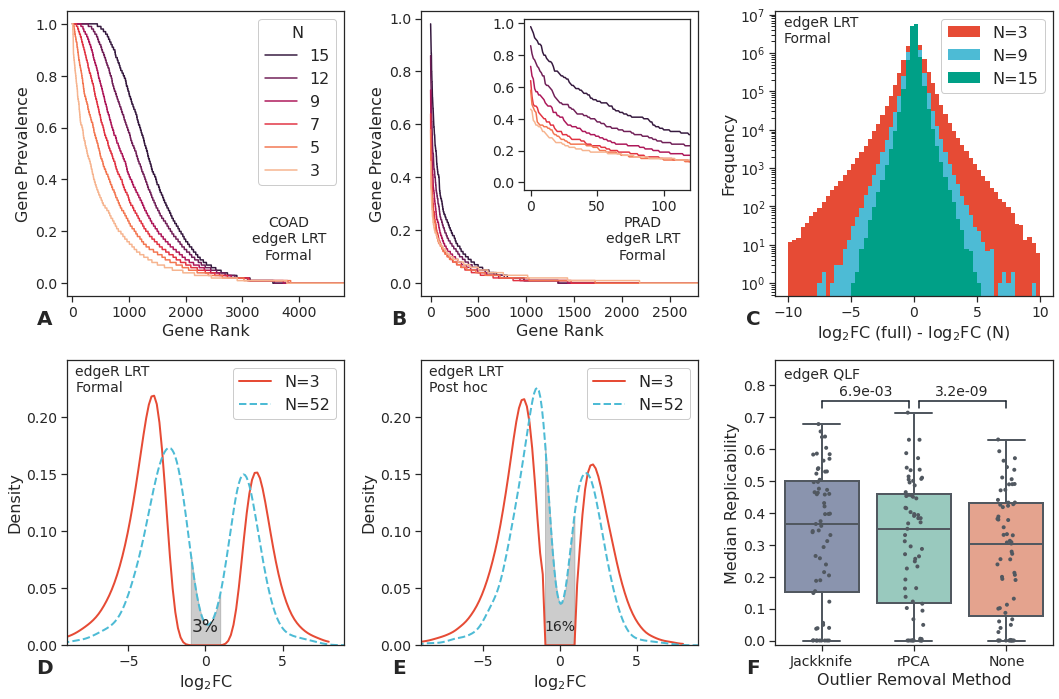

In [39]:
sns.set_style("ticks")
fig, ax = plt.subplots(2,3, figsize=(15,10),sharex=False,sharey=False)
ax = ax.flatten()
annot_font_size = 14

#### GENE PREVALENCE

dea = "edgerlrt"

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

all_N_s=[3,5,7,9,12,15]
c = sns.color_palette('rocket', len(all_N_s))
rocket = list(c)

a = 0
for d in datasets:
    site = datasets[d]["site"]
    if site not in ["colorectal","prostate"]: continue
    gene_reps = gene_reps_all_N(all_N,site,d,out,dea,FDR,logFC,"p2")
    for i, N in enumerate(reversed(all_N_s)):
        r = gene_reps[N]
        label = N #if N == 15 else N if i%2==1 else None    
        ax[a].plot(range(len(r)),r.sort_values(ascending=False),color=rocket[i],label=label)

    ax[a].legend(framealpha=1,title="N", title_fontsize=16)#, ncol=2, loc="lower left")
    ax[a].set_xlim(-100,4800 if a == 0 else 2800)
    ax[a].set(ylabel="Gene Prevalence")
    ax[a].annotate(f"{d}\nedgeR LRT\nFormal", xy=(0.8,0.20), xycoords='axes fraction', va='center',ha='center', size=annot_font_size)#,weight='bold')
    #ax[a].annotate(d, xy=(0.03,0.05), xycoords='axes fraction', va='center',ha='left')
    ax[a].set_xlabel("Gene Rank")
    
    if a == 1: ax[a].legend([],[], frameon=False)
    a+=1



inset_axes = inset_axes(ax[1],
                    width="60%", # width = 30% of parent_bbox
                    height="60%",
                    loc="upper right")

gene_reps = gene_reps_all_N(all_N,"prostate","PRAD",out,dea,FDR,logFC,"p2")
for i, N in enumerate(reversed(all_N_s)):
    r = gene_reps[N]
    label = N #if N == 15 else N if i%2==1 else None    
    inset_axes.plot(range(len(r)),r.sort_values(ascending=False),color=rocket[i],label=label)

    inset_axes.legend([],[], frameon=False)
    inset_axes.set_xlim(-5,120)
    #inset_axes.annotate("PRAD", xy=(0.7, 0.92), xycoords='axes fraction', va='center',ha='center',weight='bold')


######### FOLD-CHANGE PLOTS

FDR = 0.01
logFC = 1

cut = -1
lw = 2
alpha=1
palette = list(np.array(npg.as_hex())[[2,1,0]])
binrange=(-10,10)

##### logFC error

sns.histplot(data=df1[:cut],bins=60,binrange=binrange, ax=ax[2], palette=palette, legend=False, alpha=alpha, edgecolor="None", stat="frequency")

ax[2].legend(labels=["N=3","N=9","N=15"], framealpha=1)
ax[2].set_yscale("log")
ax[2].set_xlabel(r"log$_2$FC (full) - log$_2$FC (N)")
ax[2].annotate("edgeR LRT\nFormal", xy=(0.03, 0.93), xycoords="axes fraction", va='center',ha='left', fontsize=annot_font_size)

##### logFC inflation

palette = list(np.array(npg.as_hex())[[1,0]])

## ad hoc
ax[3].plot(x2,y2,color=npg[0],lw=lw)
sns.kdeplot(data=df22[:cut]["Truth"],clip=(-10,10), common_norm=False, color=list(np.array(npg.as_hex())[[1]])[0], legend=False, ax=ax[3],lw=lw, linestyle="--")

## post hoc    
ax[4].plot(x,y,color=npg[0],lw=lw)
sns.kdeplot(data=df2[:cut]["Truth"],clip=(-10,10), common_norm=False, color=list(np.array(npg.as_hex())[[1]])[0], legend=False, ax=ax[4],lw=lw, linestyle="--")

for a in [ax[3],ax[4]]:
    a.set_xlabel(r"log$_2$FC")
    a.legend(labels=["N=3","N=52"], framealpha=1)
    a.set_xlim(-9,9)
    a.set_ylim(0,0.25)
    a.set_yticks([0,0.05,0.1,0.15,0.2])

    # shade false positives
    xy_truth = a.get_lines()[1].get_xydata()
    x_truth = xy_truth.T[0]
    args=np.where((-1<x_truth) & (x_truth<1))
    a.fill_between(x_truth[args], xy_truth.T[1][args], color="grey",alpha=0.4)
    
    # spurious passed genes
    dfff = df2 if a == ax[4] else df22
    aa=dfff[:cut]["Truth"].dropna()
    precision = 1-len(aa[aa.abs()<=1])/len(aa[aa.abs()>1])
    a.annotate(f"{1-precision:.0%}", xy=(0.5, 0.065), xycoords="axes fraction", va='center',ha='center', fontsize=14 if a==ax[4] else 17)
    a.annotate("edgeR LRT\nPost hoc" if a==ax[4] else "edgeR LRT\nFormal", xy=(0.03, 0.93), xycoords="axes fraction", va='center',ha='left', fontsize=annot_font_size)

######### outlier
black = "#515860"
PROPS = {
    'boxprops':{'edgecolor':black},
    'medianprops':{'color':black},
    'whiskerprops':{'color':black},
    'capprops':{'color':black}
}

dea = "edgeR QLF"
fdr = 0.05
logFC = 0

c = combined_td3
c = c[(c["DEA"]==dea)&(c["FDR"]==fdr)&(c["logFC"]==logFC)&(c["N"]<15)]
c = c.loc[list(c.iloc[[0,2,1]].index) + list(c.iloc[3:].index)] # change order

sns.boxplot(data=c, x="Out", y="median_rep_adj", palette=np.array(npg)[[5,6,4]].tolist(), ax=ax[5], linewidth=2, **PROPS)
sns.stripplot(data=c, x="Out", y="median_rep_adj", color=black, ax=ax[5], size=4)
ax[5].set(xlabel="Outlier Removal Method", ylabel="Median Replicability", ylim=(-0.015,0.88))
ax[5].annotate("edgeR QLF", xy=(0.03, 0.95), xycoords="axes fraction", va='center',ha='left', fontsize=annot_font_size)

ax[5].plot((0,0.95),(0.75,0.75), color="#17202A")
ax[5].plot((0,0),(0.73,0.75), color="#17202A")
ax[5].plot((0.95,0.95),(0.75,0.73), color="#17202A")

ax[5].plot((1.05,2),(0.75,0.75), color="#17202A")
ax[5].plot((2,2),(0.75,0.73), color="#17202A")
ax[5].plot((1.05,1.05),(0.75,0.73), color="#17202A")

ax[5].text(0.48,0.78,"6.9e-03", ha="center", va="center",fontsize=annot_font_size)
ax[5].text(1.52,0.78,"3.2e-09", ha="center", va="center",fontsize=annot_font_size)

for i, aa in enumerate(ax) :
    aa.annotate(chr(ord('A')+i), xy=(-0.08, -0.08), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)

figpath = f"../figures/fig5_misc_figure.pdf"
fig.tight_layout()
fig.savefig(figpath)
print(figpath)

# Supplementary Figure 1 - Ground Truth

In [13]:
FDRs, logFCs = [0.05], [0,1, "post hoc"]
DEAs = ["edger", "edgerlrt", "deseq2"]

iterables = [datasets,[prdea[d] for d in DEAs],FDRs,logFCs]
multi_cols = pd.MultiIndex.from_product(iterables, names=["Data","DEA","FDR","logFC"])
gt = pd.DataFrame(columns=multi_cols)
for data in datasets:
    for dea in DEAs:
        for fdr in FDRs:
            for lfc in logFCs:
                col = (data,prdea[dea],fdr,lfc)
                if lfc == "post hoc":
                    gt.loc[0,col] = datasets[data]["truth_stats"][0][fdr][1][dea]
                else:
                    gt.loc[0,col] = datasets[data]["truth_stats"][lfc][fdr][lfc][dea]
                        
                        
gt=gt.unstack().reset_index(level=["Data","DEA","FDR","logFC"], drop=False)
gt.sort_values(by="DEA", inplace=True)
gt.rename(columns={0: "#DEG"}, inplace=True)

# Jaccard
iterables = [datasets,FDRs,logFCs]
multi_cols = pd.MultiIndex.from_product(iterables, names=["Data","FDR","logFC"])
gtj = pd.DataFrame(columns=multi_cols)

for data in datasets:
    for fdr in FDRs:
        for lfc in logFCs:
            col = (data,fdr,lfc)
            if lfc == "post hoc":
                gtj.loc[0,col] = datasets[data]["truth_stats"][0][fdr][1]["jaccard"]
            else:
                gtj.loc[0,col] = datasets[data]["truth_stats"][lfc][fdr][lfc]["jaccard"]
                    
gtj=gtj.unstack().reset_index(level=["Data","FDR","logFC"], drop=False)
gtj.rename(columns={0: "Jaccard"}, inplace=True)

gt=gt[gt["Data"]!="KIRC_syn_hom"]
gt["#DEG"] = gt["#DEG"].astype(float)
gtj["Jaccard"] = gtj["Jaccard"].astype(float)
gtj=gtj[gtj["Data"]!="KIRC_syn_hom"]
df = gt
gtj.index = range(len(gtj))
df.index = range(len(df))

In [14]:
order = np.array(["PRAD","LIHC","THCA","COAD","LUAD","BRCA","KIRC"])
def kf(x):
    try:
        return np.where(order==x)[0][0] # sort by data
    except IndexError:
        return x # sort by DEA
    
df = df.sort_values(by=['Data',"DEA"], key=lambda col: col.map(kf))
gtj = gtj.sort_values(by='Data', key=lambda col: col.map(kf))

../figures/sfig1_ground_truth_size.pdf


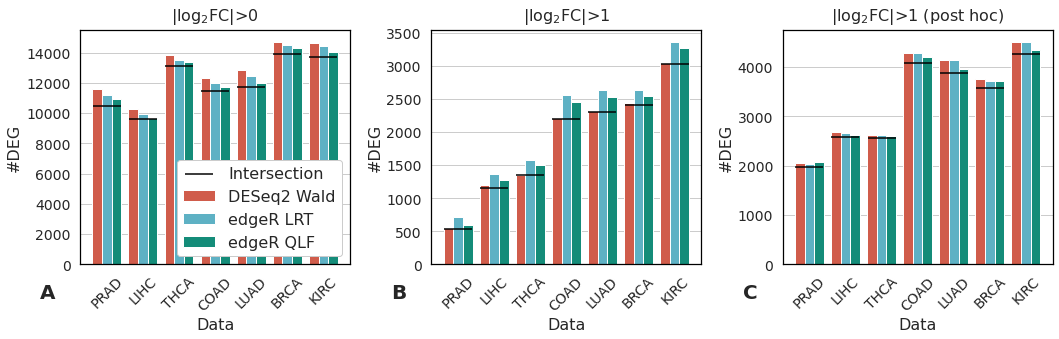

In [16]:
plt.rcParams['legend.title_fontsize'] = '15'

fig, ax = plt.subplots(1,3,figsize=(15,5), sharey=False)
ax = ax.flatten()

palette = np.array(npg)[[0,1,2]]
palette2 = np.array(npg)[[5,6,7]]

### ax[0]
dfa=df[df["logFC"]==0]
sns.barplot(data=dfa,x="Data",y="#DEG",hue="DEA", ax=ax[0],palette=palette)

### ax[1]
dfa=df[(df["logFC"]==1)]
sns.barplot(data=dfa,x="Data",y="#DEG",hue="DEA", ax=ax[1], palette=palette)

### ax[1]
dfa=df[(df["logFC"]=="post hoc")]
sns.barplot(data=dfa,x="Data",y="#DEG",hue="DEA", ax=ax[2], palette=palette)

# intersection
for i,data in enumerate(order):
    for logFC, a in zip([0,1,"post hoc"],ax[:3]):
        if logFC == "post hoc":
            logFC, logFC_test = 1, 0
        else:
            logFC_test = logFC
        inter=datasets[data]["truth_stats"][logFC_test][0.05][logFC]["inter"]
        a.scatter(i,inter,marker="_",zorder=99,color="black",s=800,label="Intersection" if i < 1 and logFC < 1 else "")

for i, a in enumerate(ax):
    a.legend([],[], frameon=False)
    a.set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='center')
    a.annotate(chr(ord('A')+i), xy=(-0.12, -0.12), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)

ax[0].set_title(r"$|\log_2\mathrm{FC}$|>0",size=16, pad=10)
ax[1].set_title(r"$|\log_2\mathrm{FC}$|>1",size=16, pad=10)
ax[2].set_title(r"$|\log_2\mathrm{FC}$|>1 (post hoc)",size=16, pad=10)


handles, labels = ax[0].get_legend_handles_labels()
labels = [l + " Wald" if l == "DESeq2" else l for l in labels]
ax[0].legend(handles, labels, loc='lower right',framealpha=1)
#ax[0].text(0.01,0.825,r"$|\log_2\mathrm{FC}$|>0", transform=ax[0].transAxes, ha="left")
#ax[1].text(0.01,0.825,r"$|\log_2\mathrm{FC}$|>1", transform=ax[1].transAxes, ha="left")


figpath = f"../figures/sfig1_ground_truth_size.pdf"
fig.tight_layout()
fig.savefig(figpath)
print(figpath)

# Supplementary Figures 2-4 - Cancer Type Metrics

\#DEGs, Replicability, and MCC vs N without (top row) and with (bottom row) formal fold-change threshold for each cancer type.

/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compar

../figures/sfig4_mcc_vs_N_data.pdf


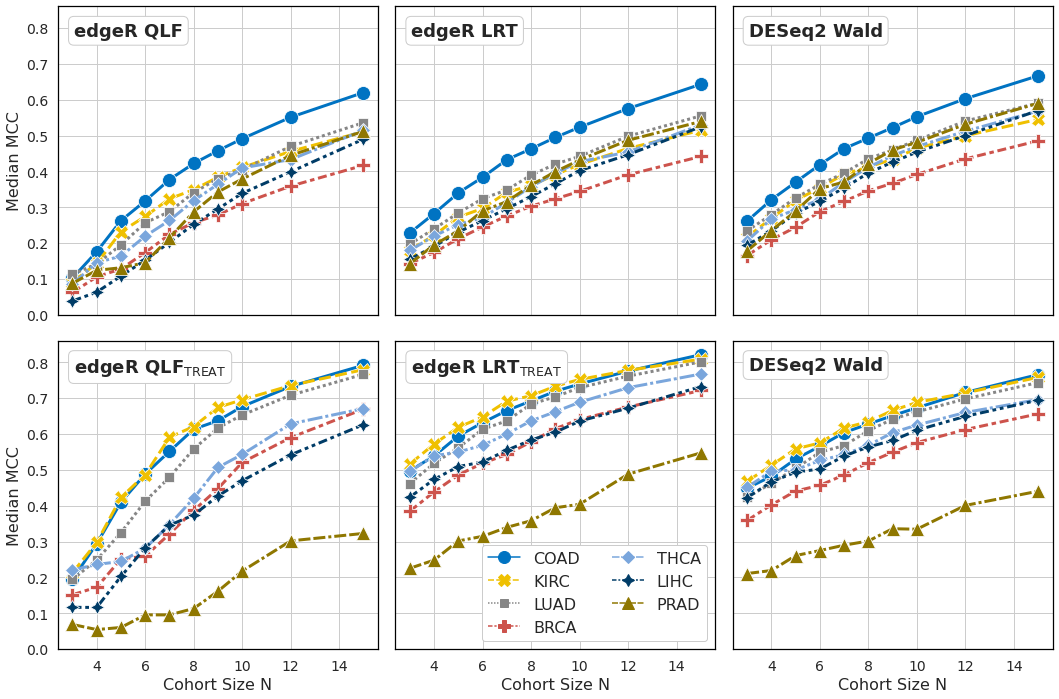

In [32]:
#met = "deg"
#met = "rep"
met = "mcc"

fig, ax = plt.subplots(2,3, figsize=(15,10), sharey=True if met != "deg" else "row", sharex=True)
palette = np.array(jco)

deas = ["edgeR QLF","edgeR LRT","DESeq2 Wald"]
logFC = 0
fdr = 0.05

prettymet = "MCC" if met == "mcc" else ("Recall" if met == "rec" else ("Precision" if met == "prec" else ("#DEG" if met == "deg" else "Replicability")))

order_rep = np.array(["COAD","KIRC","LUAD","BRCA","THCA","LIHC","PRAD"])
def kf(x):
    return np.where(order_rep==x)[0][0]
                    
for i, dea in enumerate(deas):
    for logFC in [0,1]:
        
        a = ax[logFC][i]
        c = combined_td if logFC == 0 else combined_td2
        c = c[(c["Out"]=="None") & (c["logFC"]==logFC) & (c["FDR"]==fdr)]
        c = c.sort_values(by=['Data'], key=lambda col: col.map(kf))
        cc = c[c["DEA"]==dea]

        sns.lineplot(data=cc, x="N", y=f"median_{met}", hue="Data", style="Data", markers=True, ax=a, palette=palette,lw=3,ms=14)
                
        legend_ax = ax[1][1] if met == "mcc" else ax[0][2]
        if a == legend_ax: 
            a.legend(loc='lower right',framealpha=1,title=None,ncol=2,markerscale=2)
        else: 
            a.legend([],[], frameon=False)
        
        dea_print = rf"{dea}$_\mathrm{{TREAT}}$" if dea != "DESeq2 Wald" and logFC == 1 else dea
            
        a.text(0.05, 0.95, dea_print, ha='left', va='top', transform=a.transAxes, bbox=bbox, fontsize=18, weight="bold")
        
for a in ax: a[0].set_ylabel(f"Median {prettymet}")
for a in ax[1]: a.set_xlabel("Cohort Size N")

prefix = "sfig2" if met == "deg" else "sfig3" if met == "rep" else "sfig4"
figpath = f"../figures/{prefix}_{met}_vs_N_data.pdf"
fig.tight_layout()
fig.savefig(figpath)
print(figpath)

# Supplementary Figures 9-12 - Outlier Removal

See notebook r_figures.ipynb

# Supplementary Figures 13-16 - Outlier Removal

Per cancer type

../figures/sfig15_prec_vs_N_data_outlier.pdf


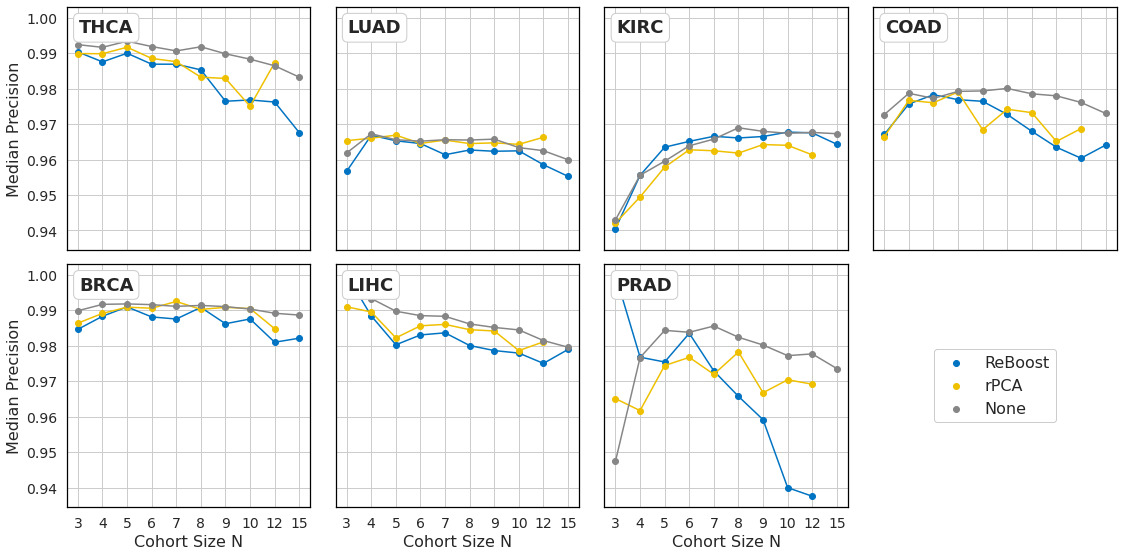

In [42]:
from misc import get_grid_size

grid = get_grid_size(len(datasets), k=0, fill=True)

met = "prec" # mcc, rep, rec, prec
FDR, logFC = 0.05, 0
outlier_method = "Jackknife"
DEA = "edgeR QLF"

prettymet = "MCC" if met == "mcc" else ("Recall" if met == "rec" else ("Precision" if met == "prec" else ("#DEG" if met == "deg" else "Replicability")))

comb_e = combined_td[(combined_td["logFC"] == logFC) & (combined_td["FDR"] == FDR) & (combined_td["DEA"]==DEA)]
fig, ax = plt.subplots(grid[0], grid[1], figsize=(grid[1]*4,grid[0]*4), sharex=True, sharey=True)
ax = ax.flatten()

for i, d in enumerate(datasets):

    comb_d = comb_e[comb_e["Data"]==d]
    comb_none= comb_d[comb_d["Out"] == "None"]
    comb_out = comb_d[comb_d["Out"] == "Jackknife"]
    
    x = comb_out["N"]
    x = range(len(x))
    
    ax[i].plot(x,comb_out[f"median_{met}_adj"],label=f"Jackknife",marker="o",color=jco[0])
    
    comb_out = comb_d[comb_d["Out"] == "rPCA"]
    ax[i].plot(x,comb_out[f"median_{met}_adj"],label=f"rPCA",marker="o",color=jco[1])
    
    ax[i].plot(x,comb_none[f"median_{met}"],label=f"None",marker="o",color=jco[2])


    #ax[i].plot(comb_out["N"],comb_out[f"median_{met}"],label=f"{d} {outlier_method}")
    #ax[i].legend(framealpha=1,title=d)
    ax[i].text(0.05, 0.95, d, ha='left', va='top', transform=ax[i].transAxes, bbox=bbox, fontsize=18, weight="bold")
    
xlim=ax[0].get_xlim()
ylim=ax[0].get_ylim()
for a in ax: 
    a.set_xlim(xlim)
    a.set_ylim(ylim)
ax[-1].scatter(-10,0,color=jco[0],label="ReBoost")
ax[-1].scatter(-10,0,color=jco[1],label="rPCA")
ax[-1].scatter(-10,0,color=jco[2],label="None")
ax[-1].legend(framealpha=1,loc="center")  

for a in ax[4:]: 
    a.set_xlabel("Cohort Size N")
    # a.set_xticks([3,4,5,6,7,8,9,10,12,15])
    a.set_xticks(x)
    a.set_xticklabels([3,4,5,6,7,8,9,10,12,15])
for a in [ax[0],ax[4]]: a.set_ylabel(f"Median {prettymet}")

for a in ax: 
    a.set_box_aspect(1)

ax[len(ax)-1].axis('off')

prefix = "sfig13" if met == "rep" else "sfig14" if met == "mcc" else "sfig15" if met == "prec" else "sfig16"
figpath = f"../figures/{prefix}_{met}_vs_N_data_outlier.pdf"
fig.tight_layout()
fig.savefig(figpath)
print(figpath)

# Supplementary Figures 17-18 - Gene Replicability

Generate figure 5 before this.

../figures/sfig17_post_hoc_gene_prevalence_data.lfc1.pdf


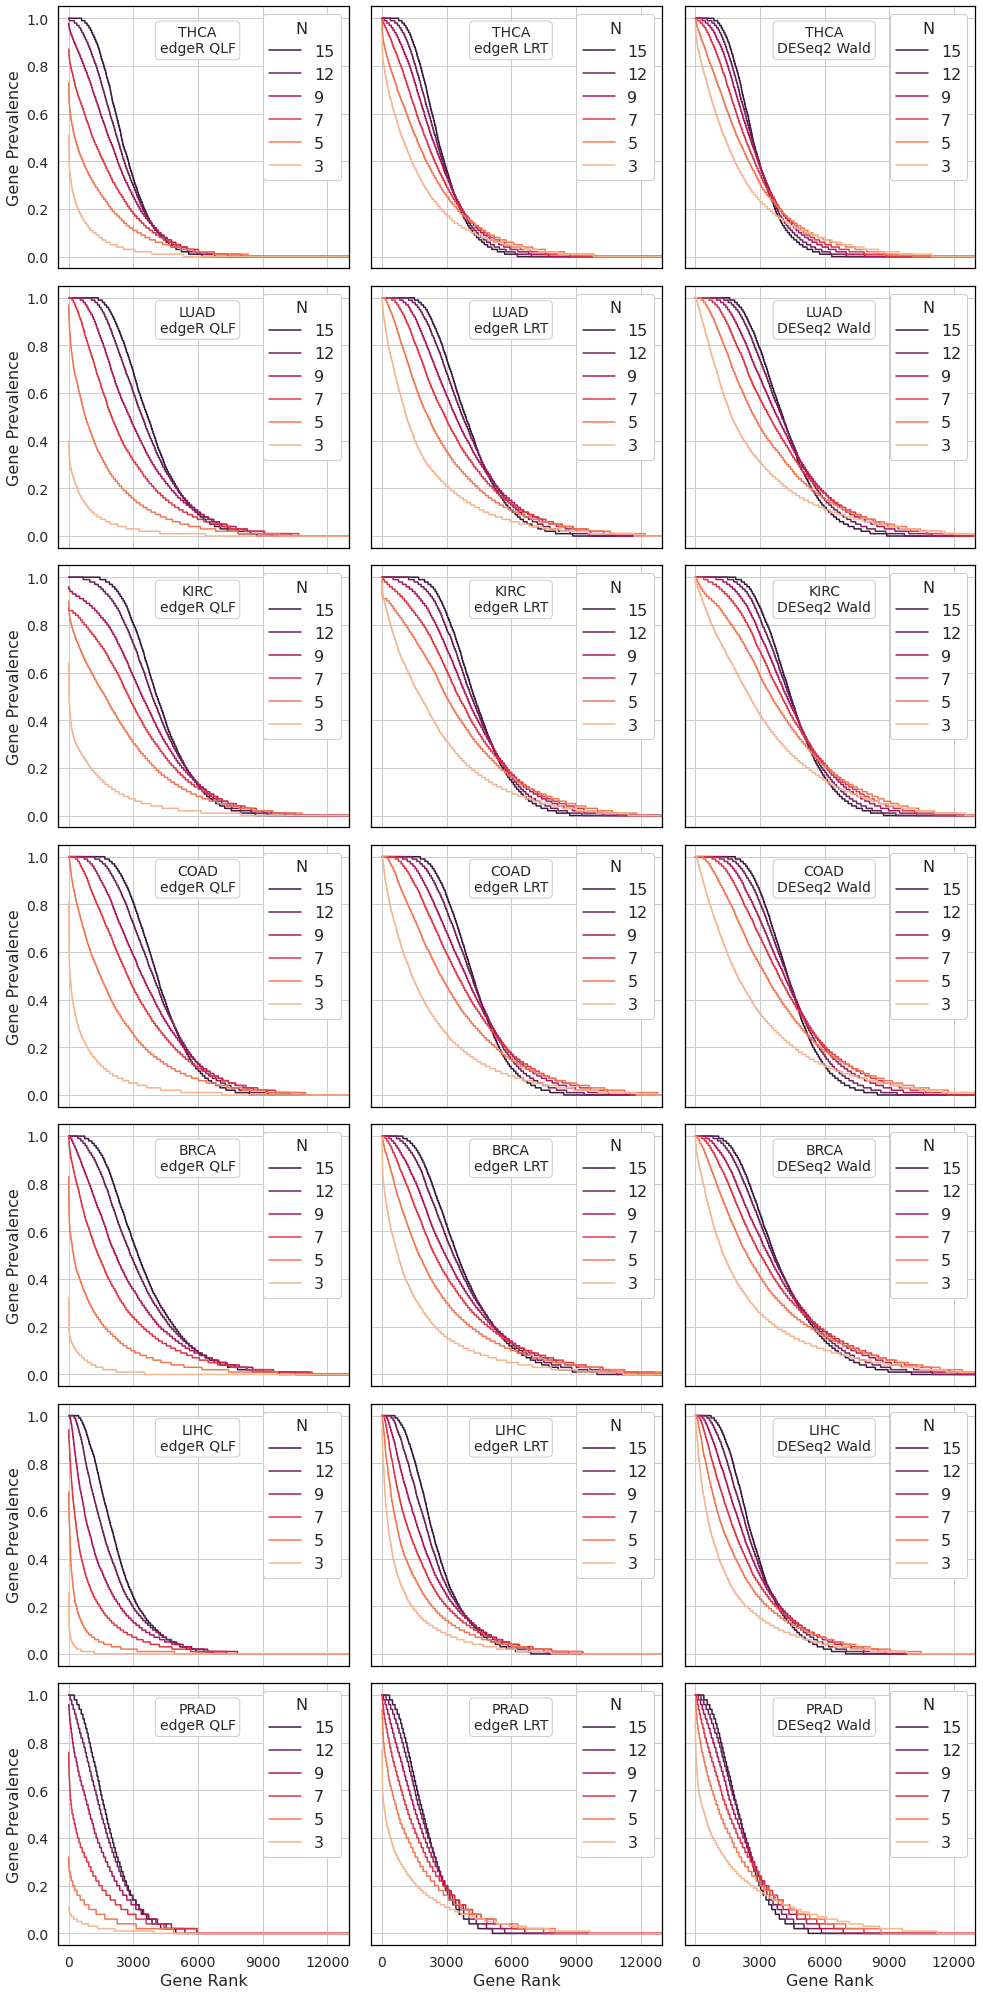

In [15]:
sns.set_style("whitegrid", {'axes.linewidth': 2, 'axes.edgecolor':'black'})
fig, ax = plt.subplots(7,3, figsize=(14,28),sharex=True,sharey=True)
annot_font_size = 14
bbox=dict(boxstyle="round", fc="1",ec="0.8")
from matplotlib import pyplot
#pyplot.locator_params(nbins=7)

#### GENE PREVALENCE

all_N = [3,4,5,6,7,8,9,10,12,15]
param_set = "p1"
dea = "edgerlrt"
FDR = 0.05
logFC = 1

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

all_N_s=[3,5,7,9,12,15]
c = sns.color_palette('rocket', len(all_N_s))
rocket = list(c)

for i, d in enumerate(datasets):
    for j, dea in enumerate(["edger","edgerlrt","deseq2"]):
        
        site = datasets[d]["site"]
        gene_reps = gene_reps_all_N(all_N,site,d,out,dea,FDR,logFC,param_set)
        
        for k, N in enumerate(reversed(all_N_s)):
            
            r = gene_reps[N]
            label = N
            ax[i][j].plot(range(len(r)),r.sort_values(ascending=False),color=rocket[k],label=label)

        ax[i][j].legend(framealpha=1,title="N", title_fontsize=16)#, ncol=2, loc="lower left")
        #ax[i][j].set_xlim(-100,4800 if a == 0 else 2800)
        if j%3==0: ax[i][j].set(ylabel="Gene Prevalence")
        ax[i][j].annotate(f"{d}\n{prdea[dea]}", xy=(0.48,0.87), xycoords='axes fraction', va='center',ha='center', size=annot_font_size, bbox=bbox)#,weight='bold')
        #ax[a].annotate(d, xy=(0.03,0.05), xycoords='axes fraction', va='center',ha='left')
        if i==6: ax[i][j].set_xlabel("Gene Rank")

        #if a == 1: ax[a].legend([],[], frameon=False)
    
for a in ax.flatten():
    a.set(xlim=(-500,13000))
    a.xaxis.set_major_locator(plt.MaxNLocator(5))

prefix = "sfig17_post_hoc" if param_set == "p1" else "sfig18_formal"

figpath = f"../figures/{prefix}_gene_prevalence_data.lfc{logFC}.pdf"
fig.tight_layout()
fig.savefig(figpath)
print(figpath)